# Gradient analysis of the neural network function

This notebook guides you through the technical details of performing a gradient analysis of the neural network function.

The procedure follows the ideas published in the paper *Identifying the Relevant Dependencies of the Neural Network Response on Characteristics of the Input Space* ([arXiv](https://arxiv.org/abs/1803.08782), [Springer](https://link.springer.com/article/10.1007%2Fs41781-018-0012-1)).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Create a toy dataset

The toy dataset consists of two classes (signal and background) to be separated based on two input variables.

The two variables are taken from a multivariate Gaussian process and allow for separation of signal and background either by their marginal distributions (difference in the means) or by correlations (difference in the covariance matrices).

Inputs:
[[ 0.97143516 -0.69097569]
 [ 1.93270697  0.1873481 ]
 [-0.22058873  1.38716294]
 ...
 [-0.78115254  0.21151299]
 [ 0.18774457 -0.34932922]
 [ 0.30066834  0.0296339 ]]
Targets:
[1. 1. 1. ... 0. 0. 0.]


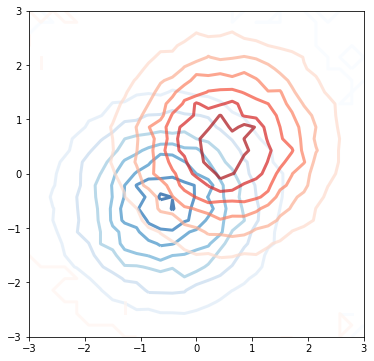

In [2]:
# Number of samples ("events") to be created per process
num_samples = 100000

# Signal process
mean_sig = np.array([0.5, 0.5])
cov_sig = np.array([[1.0, 0.0],
                    [0.0, 1.0]])
x_sig = np.random.multivariate_normal(mean_sig, cov_sig, num_samples)
y_sig = np.ones(num_samples)

# Background process
mean_bkg = np.array([-0.5, -0.5])
cov_bkg = np.array([[1.0, 0.0],
                    [0.0, 1.0]])
x_bkg = np.random.multivariate_normal(mean_bkg, cov_bkg, num_samples)
y_bkg = np.zeros(num_samples)

# Stack the inputs ("x") and class labels ("y") as a single matrix
x = np.vstack([x_sig, x_bkg])
y = np.hstack([y_sig, y_bkg])

# Print some inputs and labels
print("Inputs:\n{}".format(x))
print("Targets:\n{}".format(y))

# Plot the distributions
plt.figure(figsize=(6,6))
bins = np.linspace(-3, 3, 30)
counts, _, _, _ = plt.hist2d(x[:, 0][y == 0], x[:, 1][y == 0], bins=(bins, bins), alpha=0.0)
plt.contour(counts, extent=(-3, 3, -3, 3), linewidths=3, cmap=plt.cm.Blues, alpha=0.7);
counts, _, _, _ = plt.hist2d(x[:, 0][y == 1], x[:, 1][y == 1], bins=(bins, bins), alpha=0.0)
plt.contour(counts, extent=(-3, 3, -3, 3), linewidths=3, cmap=plt.cm.Reds, alpha=0.7);

## Define a neural network function

The neural network function is build using the Keras package. Besides the setup of the different layers of the fully connected feed-forward network, the compile step defines the optimizer and loss function for the training.

In [3]:
# Clear the Keras session in case you run the notebook multiple times
keras.backend.clear_session()

# Build the neural network
model = Sequential()
model.add(Dense(100, activation="tanh", input_shape=(x.shape[1], )))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## Fit the trainable parameters of the neural network function

Next, we fit the neural network function to our input dataset. To do so, we first split the dataset into a training and testing part and use the training part for optimizing and validating the trainable parameters.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1234)

history = model.fit(x_train, y_train,
                    batch_size = x_train.shape[0] // 10,
                    epochs = 10000,
                    callbacks=[EarlyStopping(patience=2, verbose=1)],
                    validation_split=0.25
                   )

Train on 75000 samples, validate on 25000 samples
Epoch 1/10000
75000/75000 [==============================] - 0s 4us/step - loss: 0.6643 - val_loss: 0.6253
Epoch 2/10000
75000/75000 [==============================] - 0s 3us/step - loss: 0.6016 - val_loss: 0.5732
Epoch 3/10000
75000/75000 [==============================] - 0s 3us/step - loss: 0.5565 - val_loss: 0.5389
Epoch 4/10000
75000/75000 [==============================] - 0s 2us/step - loss: 0.5278 - val_loss: 0.5180
Epoch 5/10000
75000/75000 [==============================] - 0s 2us/step - loss: 0.5107 - val_loss: 0.5062
Epoch 6/10000
75000/75000 [==============================] - 0s 3us/step - loss: 0.5011 - val_loss: 0.4998
Epoch 7/10000
75000/75000 [==============================] - 0s 3us/step - loss: 0.4959 - val_loss: 0.4964
Epoch 8/10000
75000/75000 [==============================] - 0s 2us/step - loss: 0.4933 - val_loss: 0.4948
Epoch 9/10000
75000/75000 [==============================] - 0s 1us/step - loss: 0.4920 - val_

By plotting the loss on the different split of the training dataset ("Training" is used for the gradient steps and "Validation" for the validation), we are able to study a smooth convergence and possible overfitting. In case the training stops too early, try to increase the `patience` of the early stopping callback.

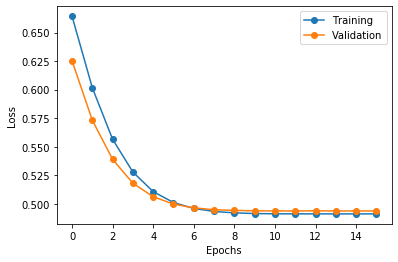

In [5]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], "o-", label="Training")
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], "o-", label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss");

## Convert the Keras model into a TensorFlow model

To study the neural network function down to the mathematical definition, we rebuild the neural network function using plain TensorFlow but reusing the weights from the Keras training. To do so, the weights are read out first and then used to initialize the TensorFlow variables.

In [6]:
weights = {}
for layer in model.layers:
    print("Layer: {}".format(layer.name))
    for weight, array in zip(layer.weights, layer.get_weights()):
        print("    weight, shape: {}, {}".format(weight.name, np.array(array).shape))
        weights[weight.name] = np.array(array)

Layer: dense_1
    weight, shape: dense_1/kernel:0, (2, 100)
    weight, shape: dense_1/bias:0, (100,)
Layer: dense_2
    weight, shape: dense_2/kernel:0, (100, 1)
    weight, shape: dense_2/bias:0, (1,)


In [7]:
# Input placeholder
# Placeholders in TensorFlow are used to feed data to the computation graph, which
# represents the neural network function.
x_ph = tf.placeholder(tf.float32)

# The variables contain the weights and biases initialized with the values from the Keras model
w1 = tf.get_variable('w1', initializer=weights['dense_1/kernel:0'])
b1 = tf.get_variable('b1', initializer=weights['dense_1/bias:0'])
w2 = tf.get_variable('w2', initializer=weights['dense_2/kernel:0'])
b2 = tf.get_variable('b2', initializer=weights['dense_2/bias:0'])

# Here we build the actual computation graph describing the neural network function
l1 = tf.tanh(tf.add(b1, tf.matmul(x_ph, w1)))
f = tf.sigmoid(tf.add(b2, tf.matmul(l1, w2)))

## Run the inference

To check the validity of our neural network function, we run a full inference step for the test dataset.

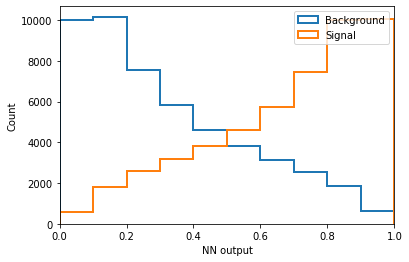

In [8]:
# TensorFlow needs a session to run the computation graph. Note that you also have to execute
# the initialization of the variables explicitely.
sess = tf.Session()
sess.run(tf.global_variables_initializer())
y_pred = sess.run(f, {x_ph: x_test})

# Plot the neural network output for the signal and background classes
bins = np.linspace(0, 1, 11)
plt.hist(y_pred[y_test == 0], bins=bins, histtype="step", lw=2, label="Background")
plt.hist(y_pred[y_test == 1], bins=bins, histtype="step", lw=2, label="Signal")
plt.legend()
plt.xlim((0, 1))
plt.xlabel("NN output")
plt.ylabel("Count");

## Perform the gradient analysis

Finally, we perform the gradient analysis. Since TensorFlow is already designed to compute the derivative of the computation graph by itself ("automatic differentiation" is the keyword), we need only a few lines of code to do so.

The gradient is computed from the neural network output `f` (in our case a scalar) to the inputs `x` (vector of size two). So in total we want to compute five derivatives:

* `df/dx1`
* `df/dx2`
* `d2f/dx1dx2`
* `d2f/dx1dx1`
* `d2f/dx2dx2`

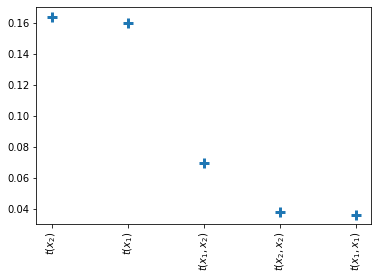

In [9]:
# Add operations to the computation graph returning the gradient
# Note that implementation of the gradient computation does an implicit sum over `y` if we compute `dy/dx`
# so that we can pass there for our purpose only a scalar.
# Documentation: https://www.tensorflow.org/api_docs/python/tf/gradients
f_dx = tf.gradients(f, x_ph)[0] # df/dx (gradient)
f_dx1dx = tf.gradients(f_dx[:, 0], x_ph)[0] # Second order derivatives d2f/dx1dx1 and d2f/dx1dx2
f_dx2dx = tf.gradients(f_dx[:, 1], x_ph)[0] # Second order derivatives d2f/dx2dx1 and d2f/dx2dx2

# Run the gradient computation
# As you can see below, the call to `run` can take a list of nodes, which are all computed efficiently
# in a single pass through the computation graph.
f_dx_, f_dx1dx_, f_dx2dx_ = sess.run([f_dx, f_dx1dx, f_dx2dx], {x_ph: x_test})

# Compute the average of the absolute values of the Taylor coefficients
# Reference to the Taylor expansion in two dimensions:
# https://en.wikipedia.org/wiki/Taylor_series#Example
t_x1 = np.mean(np.abs(f_dx_[:, 0]))
t_x2 = np.mean(np.abs(f_dx_[:, 1]))
t_x1x1 = np.mean(np.abs(0.5 * f_dx1dx_[:, 0]))
t_x1x2 = np.mean(np.abs(0.5 * 2.0 * f_dx1dx_[:, 1]))
t_x2x2 = np.mean(np.abs(0.5 * f_dx2dx_[:, 1]))

# Plot the scores
plt.plot(range(5), [t_x2, t_x1, t_x1x2, t_x2x2, t_x1x1], "+", mew=3, ms=10)
plt.xticks(range(5), ["$t(x_2)$", "$t(x_1)$", "$t(x_1, x_2)$", "$t(x_2, x_2)$", "$t(x_1, x_1)$"], rotation=90);

## And next?

Now, you can adapt the NN function by changing the input data and observe the impact on the Taylor coefficients.

* Can you identify which coefficient relates to information about the separation of signal and background in which input space?

* What happens if you stop training verly early on? Is the information about the different correlation of signal and background picked up?